In [1]:
#source EPOTFenv/bin/activate (launching and exiting the virtual environment containing the required modules, stored in the working directory for VNA_Analysis)
#EPOTFenv/bin/python your_script.py - for running a script in the virtual environment
#source deactivate

#import all the libraries needed
from import_dep import *

# import my functions stored in the file 'functions' which can then be called with functions.function_name()
import functions

# Define the path to the output directory where data is saved
path_out =  ('/Users/horatiocox/Desktop/RUG Postdoc/Experiments/Electrical/VDP_JT029_SrRuO3')
# Define the path to the directories containing the experimental data
directory_1 = Path('/Users/horatiocox/Desktop/Electronic_properties_of_thin_films/Data/')


## Import Measurement Data 

In [2]:
data_np, data_df = functions.import_ppms_data(directory_1.joinpath('JT029_SrRuO3_171024_Combined_fullrange.txt'))
print('np shape:', data_np.shape)
print(data_df.head())

np shape: (850, 5, 6)
     Temp     Field  Source (A)  Source (V)  Sense (V)  index
0  4.9985 -0.199797    -0.00001     -0.0118  -0.000010      0
1  4.9985 -0.199797    -0.00001     -0.0118   0.000112      1
2  4.9985 -0.199797    -0.00001     -0.0118  -0.000673      2
3  4.9985 -0.199797    -0.00001     -0.0118  -0.000667      3
4  4.9985 -0.199797    -0.00001     -0.0118  -0.000541      4


## Extract and Check Temperature, Field, and Current values

In [3]:
# Extract the current, temperature and field values from the data as lists along with the number of values used for each
#ctf = [current_unique, temp_unique, field_unique, current_no, temp_no, field_no]
[ctf, tf_av] = functions.extract_ctf(data_np)

# Check you have the expected and correct Temperature, Field and Current values!
#ctf = [current_unique, temp_unique, field_unique, current_no, temp_no, field_no]
print(ctf[3],'Currents:',ctf[0])  
print(ctf[4],'Temperatures:',ctf[1])
print(ctf[5],'Fields:',ctf[2])
print('Is this correct?')

5 Currents: [-1.e-05 -5.e-06  0.e+00  5.e-06  1.e-05]
17 Temperatures: [  5.  25.  45.  65.  85. 105. 125. 145. 165. 185. 205. 225. 245. 265.
 285. 305. 325.]
10 Fields: [-1.9979700e-01 -1.9979700e-01 -1.9979700e-01 -1.9979700e-01
 -1.9979700e-01  1.9999793e+04  1.9999793e+04  1.9999793e+04
  1.9999793e+04  1.9999793e+04]
Is this correct?


## Calculate Van der Pauw Resistivity 

In [4]:
film_thickness = 50e-9 # Film thickness in meters

[res_data, df_res_data, R_squared] = functions.vdp_resistivity(data_np, film_thickness, ctf, tf_av)

print(df_res_data.head())

     Temp         Field     rho_A     rho_B  rho_film
0  4.9985     -0.199797  0.000015  0.000015  0.000015
1  4.9996  19999.792969  0.000015  0.000015  0.000015
2  5.0008  39999.574219  0.000015  0.000015  0.000015
3  4.9985  59999.566406  0.000015  0.000015  0.000015
4  5.0019  79999.773437  0.000015  0.000015  0.000015


## R-squared Analysis to Check Linearity of I-V data

average R-squared = 0.9999999173893903


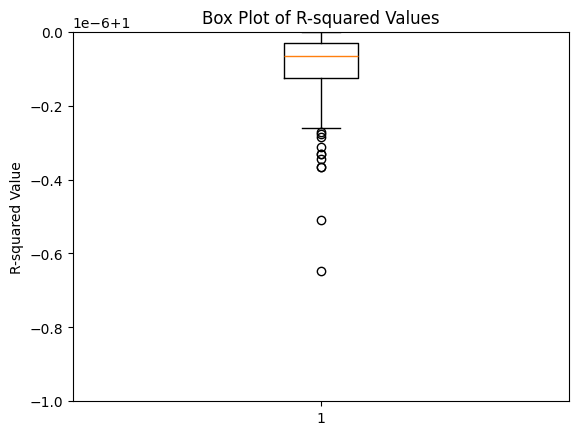

In [5]:
print('average R-squared =',sum(R_squared)/len(R_squared))

# Plot R-square values in a boxplot
# Note that the y axis is showing the deviation in 1e-6 from the perfect value of 1 so generally the values are very close to 1
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.boxplot(R_squared)
ax.set_title('Box Plot of R-squared Values')
ax.set_ylabel('R-squared Value')
ax.set_ylim(1-1e-6, 1)  # If needed, you can set x-axis limits too
plt.show()


### If you get a problem with regression, uncomment the below code to plot V vs I and check the linearity of the fit manually
# R_test = linregress(data_np[0:ctf[3]-1, 2, 2], data_np[0:ctf[3]-1, 4, 2])   
# plt.plot(data_np[0:ctf[3], 2, 2], data_np[0:ctf[3], 4, 2], 'o', label='original data')
# plt.plot(data_np[0:ctf[3], 2, 2], R_test.intercept + R_test.slope * data_np[0:ctf[3], 2, 2], 'r', label='fitted line')
# plt.legend()
# plt.show()


## Resistivity Configuration Compararison 
Comparing the resistivity in configuration A and B which are inverted versions of one another (e.g. source meter and sense meter swapped positions)
This is a good check for any systematic errors

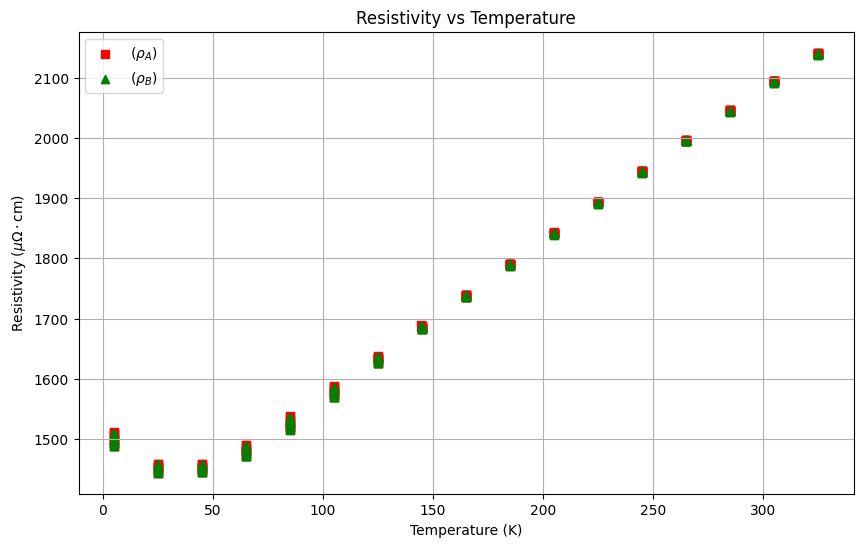

In [6]:
# Create a figure and axis
fig2 = plt.figure(figsize=(10, 6))
ax = fig2.add_subplot(111)  # Create a single subplot


# Plot R_sheet_A vs Temp
ax.scatter(res_data[:,0], res_data[:,2]* 1e8 , marker='s', color='r', label = r'($\rho_A$)')

# Plot R_sheet_B vs Temp
ax.scatter(res_data[:,0], res_data[:,3]* 1e8 , marker='^', color='g', label = r'($\rho_B$)')


# Set labels and title
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Resistivity ($\mu \Omega \cdot$cm)')
ax.set_title('Resistivity vs Temperature')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend()

# Show the plot
plt.show()

## Resistivity vs Temperature

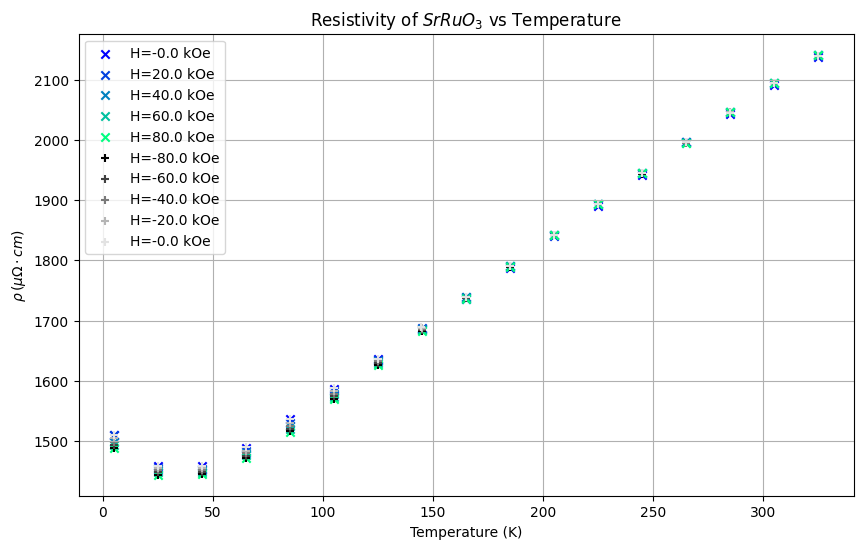

In [7]:
# Create a figure and axis
fig3 = plt.figure(figsize=(10, 6))
ax = fig3.add_subplot(111)  # Create a single subplot

#c_val = plt.cm.jet(np.linspace(0,1,num_field_points))
# Generating one set of colors for increasing positive field and one set for decreasing negative field
# higher field is brighter color in both cases
cmap1 = plt.get_cmap('winter')(np.linspace(0, 1, int(ctf[5] / 2)))
cmap2 = plt.get_cmap('Greys_r')(np.linspace(0, 0.8, int(ctf[5] / 2)))
c_val = np.vstack((cmap1, cmap2))

# Create separate marker arrays for positive and negative fields stiched together
markers = ['x'] * int(ctf[5] / 2) + ['+'] * int(ctf[5] / 2)


for k in range(ctf[5]):
    # Plot rho_film vs Temp
    ax.scatter(res_data[k::ctf[5],0], res_data[k::ctf[5],4] * 1e8, marker=markers[k], color=c_val[k], label = f'H={np.round(res_data[k,1]/1000,decimals=0)} kOe')

# Set labels and title
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\rho\,(\mu \Omega \cdot cm)$')
ax.set_title(r'Resistivity of $SrRuO_3$ vs Temperature')
# ax.set_xlim(0,100)
# ax.set_ylim(1425,1525)

# Add a grid
ax.grid(True)

# Add a legend
ax.legend()

# Show the plot
plt.show()

#fig3.savefig(Path(path_out).joinpath('resistivity_vs_temperature.png'))

## Arhenius Plot

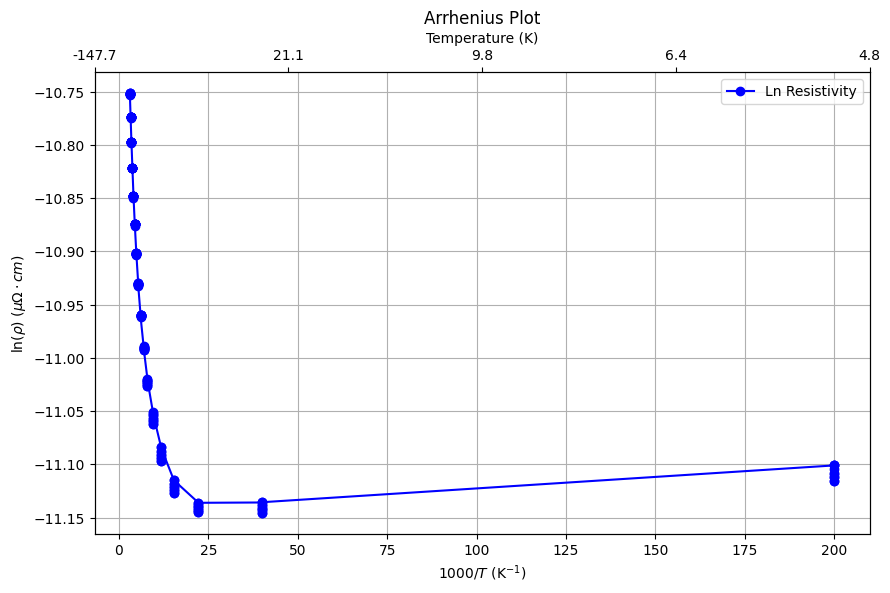

In [8]:
# Create a figure and axis
fig2 = plt.figure(figsize=(10, 6))
ax = fig2.add_subplot(111)  # Create a single subplot

# Plot rho_film vs 1000/Temp
ax.plot(1000 / df_res_data['Temp'], np.log(df_res_data['rho_film']), marker='o', linestyle='-', color='b', label='Ln Resistivity')

# Set labels and title
ax.set_xlabel(r'$1000/T$ (K$^{-1}$)')
ax.set_ylabel(r'$\ln(\rho)$ ($\mu\Omega \cdot cm$)')
ax.set_title('Arrhenius Plot')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend()

# Create a secondary x-axis at the top
ax2 = ax.twiny()

# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())

# Set the ticks and labels for the secondary x-axis
new_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=5)
ax2.set_xticks(new_ticks)
ax2.set_xticklabels([f'{1000/tick:.1f}' for tick in new_ticks])
ax2.set_xlabel('Temperature (K)')

# Show the plot
plt.show()

## Hall Measurement

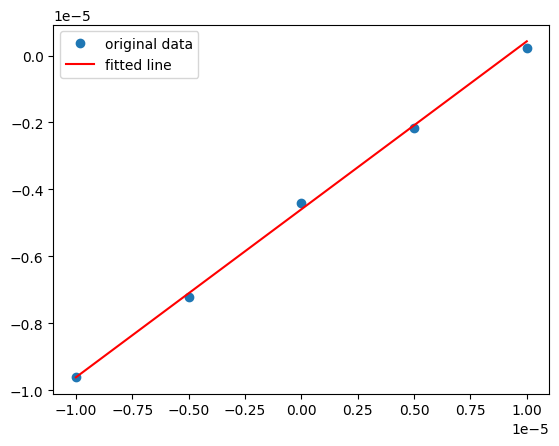

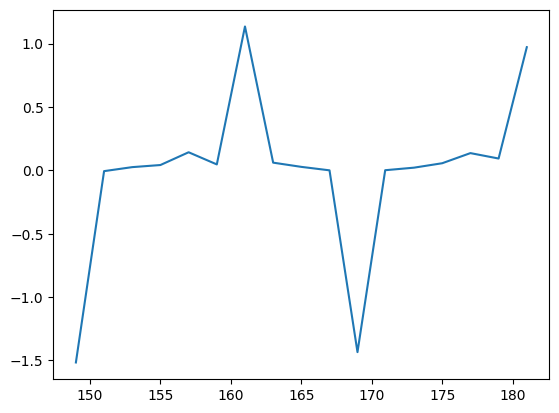

In [35]:
#def vdp_hall(data_np, film_thickness,ctf,tf_av):
# '''Calculates the hall voltage and hall coefficient from the Van der Pauw data.'''


#ctf = [current_unique, temp_unique, field_unique, current_no, temp_no, field_no]
# Find the number of measurement points at which the currents were measured (i.e each set of temperature and field values)
#points_per_index = ctf[4]*ctf[5]

# Initialise lists to store the R^2 values for the linear regression on the current-voltage and field-voltage data
R_squared_c = []
R_squared_h = []

# Initialize an empty np aray to store the hall data for each temperature
hall_data = np.zeros((ctf[3], 5))

#Loop over each temperature and field combination, calculating the sheet resistivity using the Van der Pauw method
for i in range(points_per_index):
    
    # Generate a variable to increment by the number of current points measured for each interation of the loop
    # thus going to the next measured set of currents each loop
    increment = i*ctf[3]
    
    ##### Using linear regression on the current-voltage data to obtain: 
    ### R_ij_kl[0] = the slope(resistance), R_ij_kl[1] = intercept, R_ij_kl[2] = R-squared value

    #First pair of Van der Pauw configurations
    R_32_10 = linregress(data_np[increment:ctf[3]+increment,2,2], data_np[increment:ctf[3]+increment,4,2])    
    R_20_31 = linregress(data_np[increment:ctf[3]+increment,2,3], data_np[increment:ctf[3]+increment,4,3])
    #Second pair of Van der Pauw configurations
    R_01_23 = linregress(data_np[increment:ctf[3]+increment,2,4], data_np[increment:ctf[3]+increment,4,4])
    R_13_02 = linregress(data_np[increment:ctf[3]+increment,2,5], data_np[increment:ctf[3]+increment,4,5])

    # Append the R-squared value to the list
    R_squared.extend([R_32_10[2], R_20_31[2], R_01_23[2], R_13_02[2]])

    ##### Solve the Van der Pauw equation for both pairs of configurations

    # Initial guess for rho_sheet
    initial_guess = 1.0

    # Solve for rho_sheet for the first pair (R_A)
    R_sheet_A = fsolve(vdp_equation, initial_guess, args=(R_32_10[0], R_20_31[0]))[0]

    # Solve for rho_sheet for the second pair (R_B)
    R_sheet_B = fsolve(vdp_equation, initial_guess, args=(R_01_23[0], R_13_02[0]))[0]

    # Average the two solutions for the final sheet resistivity
    R_sheet = (R_sheet_A + R_sheet_B) / 2
    
    # Step 3: Insert the new row to the np data array
    res_data[i,:] = [tf_av[i,0], tf_av[i,1], R_sheet_A*film_thickness, R_sheet_B*film_thickness,R_sheet*film_thickness]

# Convert the numpy array to a pandas dataframe then return the data in both forms along with the R-squared values
df_res_data = pd.DataFrame(res_data, columns=['Temp', 'Field', 'rho_A', 'rho_B','rho_film'])
return res_data, df_res_data, R_squared

In [30]:
print(data_np[int(current_no*(field_no/2)):int(current_no*(field_no/2))+current_no,2,0])
print(int(current_no*(field_no/2)),int(current_no*(field_no/2))+current_no)


[-1.e-05 -5.e-06  0.e+00  5.e-06  1.e-05]
25 30


In [ ]:




total = pandas.read_csv(path_1.joinpath('a30037_0 (19) - SiO_2-.txt'),sep=' ',skiprows=10, header = None) 
data = total[3]
frames = [total[0].iloc[-1]+1, total[1].iloc[-1]+1, total[2].iloc[-1]+1] #frames stores the size of the data array e.g. resolution of image - got rid of zero indexing
print(frames)
data = data.to_numpy()

mat = np.zeros([np.size(data),6])
mat.shape

mat[:,1] = data
#total stored in zero
#oxygen stored in 1
#Silicon stored in 2
#gold stored in 3
#hydrogen stored in 4
#sio2 stored in 5


# Feeding Data into an np array and reshaping to 3D
mathi = mat.reshape((frames[2],frames[1],frames[0],6))
mathi = np.transpose(mathi,(1,2,0,3))

print(mathi.shape)
#mat = np.sum(mat,axis=0)

#saving the data
np.save(path_1.joinpath('sims2437.npy'), mathi)

In [ ]:

#R_{32,10} = (V_{10}(I^+_{32}) - V_{10}(I^-_{32})) / (I^+_{32} - I^-_{32})
R_32_10 = (edat[4::5,4,2] - edat[0::5,4,2]) / (edat[4::5,2,2] - edat[0::5,2,2])

#R_{20,31} = (V_{31}(I^+_{20}) - V_{31}(I^-_{20})) / (I^+_{20} - I^-_{20})
R_20_31 = (edat[4::5,4,3] - edat[0::5,4,3]) / (edat[4::5,2,3] - edat[0::5,2,3])

print(R_32_10.shape, R_20_31.shape)

q1 = R_32_10/R_20_31
q2 = R_20_31/R_20_31
        
- rho^A_sheet = (pi * f / ln(2)) * (R_{32,10} + R_{20,31}) / 2
- (q - 1) / (q + 1) = (f * cosh^(-1)(e^(ln(2)/f) / 2)) / ln(2)
- Where f can be taken from tables and q = max(R_{32,10}/R_{20,31}, R_{20,31}/R_{32,10})

#R_{01,23} = (V_{23}(I^+_{01}) - V_{23}(I^-_{01})) / (I^+_{01} - I^-_{01})
R_01_23 = (edat[4::5,4,4] - edat[0::5,4,4]) / (edat[4::5,2,4] - edat[0::5,2,4])

#R_{13,02} = (V_{01}(I^+_{13}) - V_{02}(I^-_{13})) / (I^+_{13} - I^-_{13})
R_20_31 = (edat[4::5,4,5] - edat[0::5,4,5]) / (edat[4::5,2,5] - edat[0::5,2,5])
    
- rho^A_sheet = (pi * f / ln(2)) * (R_{01,23} + R_{13,02}) / 2
- (q - 1) / (q + 1) = (f * cosh^(-1)(e^(ln(2)/f) / 2)) / ln(2)
- Where f can be taken from tables and q = max(R_{01,23}/R_{13,02}, R_{13,02}/R_{01,23})

#Final resistivity: given at every field and temperature
rho_vdp = (rho^A_sheet + rho^B_sheet) / 2
print(rho_vdp.shape)

#extracting Temperature, Field, Source (A) into np array with same indexing as rho
#This should therefore have the same number of rows as rho
parameters_vdp = np.divide((edat[0::5,0:2,2]+edat[1::5,0:2,2]+edat[2::5,0:2,2]+edat[3::5,0:2,2]+edat[4::5,0:2,2]),2)
print(parameters_vdp.shape[0])

if parameters_vdp.shape[0] == rho_vdp.shape:
    print('Shapes match')
else:
    print('Shapes do not match')
    
    if iterate_lines == True:
                line_obj = next(line_style_iterator) #get the first line style to pass as a plotting argument
                
                
data_sliced.plot_s_smith(m=mm,n=nn,draw_labels=True, color=colors[color_count],
                                                                linestyle = line_obj, label = f'S_{mm}{nn} {dev.filename}')

In [ ]:
line_style_iterator = itertools.cycle(line_styles) #makes an iterator object that can be cyled through with next() to get the next line style
    color_maps = ['Greys_r','winter','autumn','Greens', 'Purples','Blues', 'Oranges',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn','Reds'] #list of sequential color maps to cycle through for each subset
    color_map_iterator = itertools.cycle(color_maps)
    color_obj = next(color_map_iterator)
    
colors = plt.get_cmap(color_obj)(np.linspace(0.1,0.9,num_colors))
            color_count = 0 #initiate color count to cycle through the colors for each device in the subset
            
            